In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 
import matplotlib.pyplot as plt

In [2]:
!which python

/usr/bin/python


In [3]:
import sklearn

In [5]:
from fushiming.mthesis.const import get_cols
from fushiming.mthesis.const import get_vecs

In [6]:
import pandas as pd
import numpy as np

In [7]:
import librosa

In [11]:
from librosa.core.spectrum import _spectrogram

In [12]:
cruise="jare60"

In [13]:
#era5 = pd.read_pickle("./dataset/cruise/{c}/{c}_era5_filled.pkl".format(c=cruise)).resample("S").nearest()
era5 = pd.read_pickle("~/Dataset/{c}_era5_filled.pkl".format(c=cruise))[["mwp", "t2m", "sst", "mwd", "tp", "swh", "u10", "v10"]].resample("S").nearest()

In [14]:
spc = pd.read_pickle("~/Dataset/{c}_spc_all.pkl".format(c=cruise))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nakamurataiki/Dataset/jare60_spc_all.pkl'

In [9]:
spray = pd.read_pickle("~/Dataset/{c}_all.pkl".format(c=cruise))

In [10]:
import datetime
td = datetime.timedelta(hours=9)
spray.index = spray.index - td

In [11]:
df = spray.merge(era5, left_index=True, right_index=True)
df = df.merge(spc, left_index=True, right_index=True)

In [17]:
df_saved = df.copy()
#df_saved

In [222]:
df_saved.to_pickle('~/Dataset/backup_df.zip')

In [16]:
#df_copy = pd.read_pickle('~/Dataset/backup_df.zip')
df_copy = pd.read_pickle('/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60/backup_df.zip')

In [17]:
df = df_copy

In [19]:
del_list = [
       '中央Ax (m/s2)', '中央Ay (m/s2)', '中央Az (m/s2)', '南北速度 (kt)',
       '右散水流量 (m3/min)', '回転数調整', '左散水流量 (m3/min)', '東西速度 (kt)', '舵角　右舵 (度)',
       '舵角　左舵 (度)', '船尾Ax (m/s2)', '船尾Ay (m/s2)', '船尾Az (m/s2)', '船首Ax (m/s2)',
       '船首Ay (m/s2)', '船首Az (m/s2)', 'temp[degC]', '計測ノッチ', '速力指令　右',
       '速力指令　左', '速力 (kt)']

In [20]:
for i in del_list:
    del df[i]

In [21]:
df = df.rename(columns={'速度 (kt)' : 'Speed[knot]', '艦首方位 (度)':'Course[deg]'})

In [22]:
def polar2xy(df, vec):
    #極座標パラメーターを直交座標パラメーターに変換
    speed = vec[0]
    degree = vec[1]
    v_x = df[speed]*np.cos(df[degree]/180*np.pi) #南北or 船首
    v_y = df[speed]*np.sin(df[degree]/180*np.pi) #東西or 船側
    df["{}_x".format(speed)] = v_x
    df["{}_y".format(speed)] = v_y
    return df

In [23]:
vec_list = [
['Speed[knot]', 'Course[deg]'],
['Relative wind speed[m/s]'     , 'Relative wind direction[deg]']]

In [24]:
df["Relative wind direction[deg]"] = np.rad2deg(np.arccos(df['相対風速 (m/s)_cos']/df['相対風速 (m/s)']))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


In [25]:
df = df.rename(columns={'相対風速 (m/s)':'Relative wind speed[m/s]'})

In [26]:
for vec in vec_list:
    if vec[0] in df.columns:
        df = polar2xy(df, vec)

In [27]:
df.columns

Index(['ピッチ (度)', 'ピッチレート (度/秒)', 'ヨーレート (度/秒)', 'ロール (度)', 'ロールレート (度/秒)',
       'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin',
       '経度 (度)', '緯度 (度)', 'Course[deg]', 'Speed[knot]', 'mwp', 't2m', 'sst',
       'mwd', 'tp', 'swh', 'u10', 'v10', 'Unix Time', 'particle[/mm2]',
       'total vol[mm3]', 'SPC_flux[mm]', 'Relative wind direction[deg]',
       'Speed[knot]_x', 'Speed[knot]_y', 'Relative wind speed[m/s]_x',
       'Relative wind speed[m/s]_y'],
      dtype='object')

In [ ]:
def resample(df,freq="T", sep_tp=0.01, sep_swh=0.5):
    df = df.drop_duplicates().dropna().sort_index().resample("S").nearest(300)

    tmp = df.resample(freq).mean()
    len_raw = len(df)//60
    # 雨を除外
    tmp = tmp.loc[tmp['tp'] <= sep_tp*0.001, :]
#     # 風を除外
    #tmp = tmp.loc[tmp['Relative wind speed[m/s]_y'] > 0, :]
    tmp = tmp.loc[tmp['swh'] > sep_swh, :]
    print("avalable data ratio:{} %".format(len(tmp)/len_raw*100), len(tmp))
    return tmp

In [ ]:
df_resampled = resample(df)

In [ ]:
df_resampled.to_pickle('./dataset/cruise/jare60/resampled_data.zip')

In [ ]:
df_resampled.columns

In [ ]:
df_resampled = pd.read_pickle('./dataset/cruise/jare60/resampled_data.zip')

In [ ]:
def rose(tmp, value, direction, title, name, mode="wind"):
    import fushiming.graph.polar as polar
    ws = tmp[value]
    dr = tmp[direction]
    if mode == "wave":
        dr = dr + 180
#     dr[dr < 0] = dr+360
#     dr[dr>360]=dr-360
    wr = polar.windrose(dr, ws)
    wr.label_to_degree()
    number_of_sections = 16
    wr.draw_bar(bins=6, title=title, name = name, mode=mode, nsector=number_of_sections*10,
                       fontsize=15)

In [ ]:
df_resampled["Relative wind direction[deg]"] = 360 - (df_resampled["Relative wind direction[deg]"] - 90)

In [ ]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm

fontsize = 15
ax = WindroseAxes.from_ax()
ax.bar(df_resampled["Relative wind direction[deg]"], df_resampled['Relative wind speed[m/s]'],
           normed=True, opening=0.8, edgecolor='white', nsector=160, bins=np.arange(0, 25, 5))
ax.set_legend(fontsize=fontsize)
ax.tick_params(labelsize = fontsize)
ax.set_thetagrids(angles=ax.theta_angles, labels=[90, 45, 0, 315, 270, 225, 180, 135])
#ax.legend(fontsize=fontsize,bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
plt.title("Relative wind rose", fontsize=fontsize)
rose_file = "./dataset/cruise/jare60/windrose_shirase.png"
plt.savefig(rose_file)
plt.show()

## 出会い周期

航行する船舶が体感で感じる波の周期のこと．
海洋波の周期（era5のmwpに相当，ただしこれは一時間おき），船舶の速度，相対波向（era5のmwdの単位はdegreeのため，そのまま代入すれば良い）から求められる．

### 相対波向
船舶の進路方向から見た波向．

- 相対波向：\$ \chi[deg] \$
- 船舶方向：\$ D[deg]\$
- 波向：\$ W[deg]\$

$$
\chi = D - W
$$

- 海洋波の周期: \$ T_{w} \$
- 船舶の速度：\$ V \$
- 出会い周期：\$T_{e}\$

$$
T_{e} = \frac{\frac{gT_{w}^2}{2\pi}}{\frac{gT_{w}}{2\pi} + Vcos\chi} 
$$

<img src="./dataset/cruise/jare60/from_mwd_to_course.png" width="300" height="300">

In [29]:
df_resampled = df

In [30]:
df_resampled['mwd'] = df_resampled['mwd'] - 180
df_resampled['mwd'] = df_resampled['mwd'].where(
                                                                    df_resampled['mwd'] >= 0,
                                                                    df_resampled['mwd'] + 360)

In [31]:
df_resampled['Relative wave direction[deg]'] = df_resampled['Course[deg]'] - df_resampled['mwd']

In [32]:
df_resampled['Relative wave direction[deg]'] = df_resampled['Relative wave direction[deg]'].where(
                                                                    df_resampled['Relative wave direction[deg]'] >= 0,
                                                                    df_resampled['Relative wave direction[deg]'] + 360)

In [33]:
df_resampled['Speed[m/s]'] = df_resampled['Speed[knot]'] * 0.5144

In [34]:
g = 9.8
df_resampled['encounter cycle'] = (g * df_resampled['mwp'] ** 2 / (2 * np.pi)) / ((g * df_resampled['mwp'] / (2 * np.pi)) + df_resampled['Speed[m/s]'])

In [35]:
for_hist_list = ['encounter cycle', 'ピッチ (度)', 'Speed[knot]', 'Relative wind speed[m/s]_y', 'swh']
for_hist_name = ['Average encounter\nperiod[s]', 'Pitch amplitude[deg]', 'Ship speed[knot]',
                          'Wind speed\nfrom bow direction[m/s]', 'Significant wave\nheight[m]']

In [36]:
#df_resampled = df_resampled[df_resampled['encounter cycle'] >= 0]
#df_resampled = df_resampled[df_resampled['encounter cycle'] <= 20]

ValueError: max must be larger than min in range parameter.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily

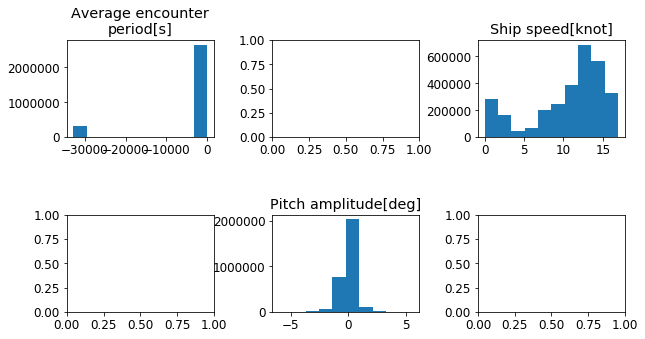

In [277]:
from matplotlib import rcParams
#import japanize_matplotlib

rcParams['font.family'] = 'IPAexGothic'
rcParams.update({'font.size': 12})

# 1次元histを描画
def draw_1dhist(df, cols, name, file_name):
    plt.subplots_adjust(wspace=1.1, hspace=0.8)
    for i, col in enumerate(cols):
        plt.subplot(2, 3, i+1)
        plt.hist(df[col])
        plt.title(name[i])
    plt.savefig(file_name)
    plt.show()
    
def draw_1dhist_test(df, cols, name, file_name):
    fig, ax = plt.subplots(2, 3, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    for i, col in enumerate(cols):
        ax[i%2, i%3].hist(df[col])
        ax[i%2, i%3].set_title(name[i])
    ax[1, 2].tick_params(labelbottom=False,
                                                  bottom=False,
                                                 labelleft=False,
                                                 left=False)
    ax[1, 2].spines["right"].set_color("none")  # 右消し
    ax[1, 2].spines["left"].set_color("none")   # 左消し
    ax[1, 2].spines["top"].set_color("none")    # 上消し
    ax[1, 2].spines["bottom"].set_color("none") # 下消し
    plt.savefig(file_name)
    plt.show()
    
hist_path = "./dataset/cruise/jare60/1dhist_shirase_fixed.png"
draw_1dhist_test(df_resampled, for_hist_list, for_hist_name, hist_path)

In [ ]:
spc_data = df_resampled['SPC_flux[mm]']
for_2dhist_plot = [ 'Significant wave\nheight[m]', 'Ship speed[knot]', 'Pitch amplitude[deg]', 
                     'Wind direction\nrelative to ship cource[deg]', 'Wind speed\nrelative to ship speed[m/s]', 'Wind speed\nfrom bow direction[m/s]',
                          'Average encounter period[s]']
extracted_data = ['swh', 'Speed[knot]', 'ピッチ (度)', 'Relative wind direction[deg]',
                           'Relative wind speed[m/s]', 'Relative wind speed[m/s]_y', 'encounter cycle']

In [ ]:
df_resampled['Relative wind direction[deg]'] = df_resampled['Relative wind direction[deg]'] - 90

In [ ]:
from matplotlib import rcParams,colors

num=2
plt.subplots_adjust(wspace=0.2, hspace=13)
rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')

for i, col in enumerate(extracted_data):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(wspace=0.5, hspace=1.4)
    plt.hist2d(df_resampled[col], spc_data,
                   bins=40, norm=colors.LogNorm(vmin=1, vmax=150))
    plt.xlabel(for_2dhist_plot[i])
    plt.ylabel('SPC[mm]')
    plt.colorbar()
    plt.ylim([0, 50])
plt.savefig("./dataset/cruise/jare60/2dhist_shirase.png")
plt.show()

# ERA5からの海水飛沫予測

「しらせ」の船速・船向とERA5のデータセットを組み合わせることにより，飛沫発生時の海象の傾向を見ることを目的とする．また，ERA5データセットの気象・海象データから解析データ内の飛沫発生を予測できないかを探ることとする．

## 船長波長比と飛沫量の関係
伏見さんの修論中では，船体波長比と飛沫量との間に相関が見られる．この船体波長比は以下の式で計算できる．

- 海洋波の周期(ERA5より取得): \$ T_{w} \$
- 海洋波の波長: \$ \lambda \$

$$
\lambda = \frac{gT_{w}^2}{2\pi}
$$

- 船長: \$ L \$
- 船体波長比: \$ M \$

$$
M = \frac{\lambda}{L}
$$

In [37]:
# 船体波長比を算出(しらせ2代目)
L = 138.0
df_resampled['wave_length'] = g * df_resampled['mwp']**2 / (2 * np.pi)
df_resampled['ratio'] = df_resampled['wave_length'] / L

## ERA5の風速・風向データを用いた飛沫量予測
具体的には，ERA5の10u, 10vを用いる．

- 10u: 地上10mにおける，風速の東西方向成分．東に向かって吹く場合を正．
- 10v: 地上10mにおける，風速の南北方向成分．北に向かって吹く場合を正．

<img src="./dataset/cruise/jare60/how_to_calc_wind_direction.png" width="300" height="300">

In [38]:
# 絶対風向値を算出
df_resampled['era5_abs_wind_direction'] = np.rad2deg(np.arctan(df_resampled['v10'] / df_resampled['u10']))
df_resampled['era5_abs_wind_direction'] = df_resampled['era5_abs_wind_direction'].where(
                                                                    df_resampled['era5_abs_wind_direction'] >= 0,
                                                                    df_resampled['era5_abs_wind_direction'] + 360)

In [39]:
# 船舶進路から見た相対風向を算出
df_resampled['era5_rel_wind_direction'] = df_resampled['Course[deg]'] - df_resampled['era5_abs_wind_direction']

In [40]:
# 修正
df_resampled['era5_rel_wind_direction'] = df_resampled['era5_rel_wind_direction'].where(
                                                                    df_resampled['era5_rel_wind_direction'] >= 0,
                                                                    df_resampled['era5_rel_wind_direction'] + 360)

In [41]:
# 船首方向からの風速を追加
df_resampled['era5_wind_speed'] = np.sqrt(df_resampled['u10'] ** 2 + df_resampled['v10'] ** 2)
df_resampled['era5_wind_speed_from_the_bow'] = -1 * np.cos(df_resampled['era5_rel_wind_direction']) * \
                                                                                    df_resampled['era5_wind_speed']

### ERA5の海象・気象予報データと飛沫量の2次元ヒストグラム
主に，以下の海象・気象予報データを用いる．

- 出会い周期
- 相対波向
- 船長波長比
- 有義波向
- 相対風向
- 船首方向からの風速

In [ ]:
extracted_data_era5 = ['encounter cycle', 'Relative wave direction[deg]', 'ratio', 'swh', 'era5_rel_wind_direction', 
                             'era5_wind_speed_from_the_bow']
name_era5 = ['Average encounter period[s]', 'Wave direction\nrelative to ship cource[deg]', 
                    'ratio between the ship length\nand the wave length', 'Significant wave\nheight[m]',
                    'Wind direction\nrelative to ship cource[deg]', 'Wind speed\nfrom bow direction[m/s]']

In [ ]:
from matplotlib import rcParams,colors

num=2
rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')

for i, col in enumerate(extracted_data_era5):
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=1.4)
    plt.hist2d(df_resampled[col], spc_data,
                   bins=40, norm=colors.LogNorm(vmin=1, vmax=150))
    plt.xlabel(name_era5[i])
    plt.ylabel('SPC[mm]')
    plt.colorbar()
    plt.ylim([0, 50])
plt.savefig("./dataset/cruise/jare60/2dhist_era5.png")
plt.show()

# スペクトログラム

In [68]:
pitch_from_df = np.array(df_resampled['ピッチ (度)'])

In [ ]:
def resample(df,freq="T", sep_tp=0.01, sep_swh=0.5):
    df = df.drop_duplicates().dropna().sort_index().resample("S").nearest(300)

    tmp = df.resample(freq).mean()
    len_raw = len(df)//60
    # 雨を除外
    tmp = tmp.loc[tmp['tp'] <= sep_tp*0.001, :]
#     # 風を除外
    #tmp = tmp.loc[tmp['Relative wind speed[m/s]_y'] > 0, :]
    tmp = tmp.loc[tmp['swh'] > sep_swh, :]
    print("avalable data ratio:{} %".format(len(tmp)/len_raw*100), len(tmp))
    return tmp

In [104]:
df_resampled['swh'].describe()

count    2.971233e+06
mean    -3.497123e+03
std      1.012128e+04
min     -3.276700e+04
25%      1.773990e+00
50%      2.404550e+00
75%      3.353646e+00
max      4.918474e+00
Name: swh, dtype: float64

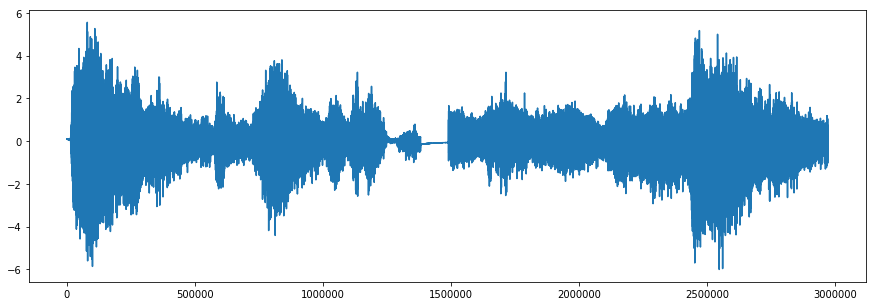

In [79]:
plt.figure(figsize=(15,5))
plt.plot(np.array(pitch_from_df))

In [72]:
#S, n_fft = _spectrogram(y=pitch_from_df, n_fft=64, hop_length=1, power=2)
S = np.abs(librosa.core.stft(pitch_from_df, n_fft=64, hop_length=1, window='hann'))

In [80]:
S.shape

(33, 2971234)

In [76]:
import librosa.display

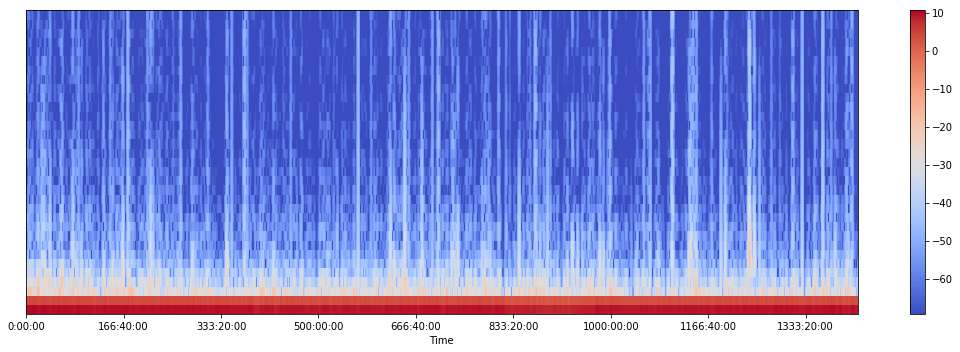

In [91]:
plt.figure(figsize=(15,5))
#librosa.display.specshow(librosa.amplitude_to_db(S[:, :10000], ref=np.max), sr=1, x_axis='time')
librosa.display.specshow(librosa.amplitude_to_db(S[:, :10000]), sr=1, x_axis='time')
#plt.colorbar(format='%+2.0f dB')
plt.colorbar()
plt.tight_layout()
plt.show()

In [63]:
S_db = librosa.power_to_db(S, ref=np.max)
S_db

array([[-31.73147202, -31.73195839, -31.73342133, ..., -28.99373817,
        -28.97701263, -28.99373817],
       [-37.70583725, -37.70576096, -37.70552444, ..., -30.68371391,
        -30.66408157, -30.68371391],
       [-78.70020294, -78.79930115, -79.10617065, ..., -42.65015411,
        -42.85601425, -42.65015411],
       ..., 
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -75.64347076,
        -75.72259521, -75.64347076],
       [-80.        , -80.        , -80.        , ..., -78.39039612,
        -78.23048401, -78.39039612]], dtype=float32)

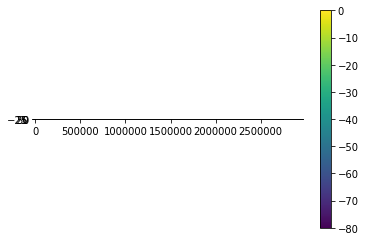

In [62]:
S_db = librosa.power_to_db(S, ref=np.max)
plt.imshow(S_db)
#librosa.display.specshow(S_db, x_axis='time', y_axis='freq')
plt.colorbar()

# 飛沫予測

## 船体運動のピッチを処理
船体運動のピッチを

In [158]:
df_resampled.columns

Index(['ピッチ (度)', 'ピッチレート (度/秒)', 'ヨーレート (度/秒)', 'ロール (度)', 'ロールレート (度/秒)',
       'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin',
       '経度 (度)', '緯度 (度)', 'Course[deg]', 'Speed[knot]', 'mwp', 't2m', 'sst',
       'mwd', 'tp', 'swh', 'u10', 'v10', 'Unix Time', 'particle[/mm2]',
       'total vol[mm3]', 'SPC_flux[mm]', 'Relative wind direction[deg]',
       'Speed[knot]_x', 'Speed[knot]_y', 'Relative wind speed[m/s]_x',
       'Relative wind speed[m/s]_y', 'Relative wave direction[deg]',
       'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio',
       'era5_abs_wind_direction', 'era5_rel_wind_direction', 'era5_wind_speed',
       'era5_wind_speed_from_the_bow'],
      dtype='object')

In [165]:
df_resampled.corr().loc['SPC_flux[mm]', :]

ピッチ (度)                         2.176484e-03
ピッチレート (度/秒)                   -1.055705e-04
ヨーレート (度/秒)                     6.321371e-07
ロール (度)                         6.305796e-03
ロールレート (度/秒)                    5.860086e-04
Relative wind speed[m/s]        9.728713e-02
相対風速 (m/s)_cos                  4.182954e-02
相対風速 (m/s)_sin                 -9.493095e-04
経度 (度)                          1.830225e-02
緯度 (度)                         -6.094309e-03
Course[deg]                    -3.276635e-02
Speed[knot]                    -5.367553e-02
mwp                             1.822394e-02
t2m                             4.636935e-03
sst                             3.756296e-03
mwd                             1.867844e-02
tp                              4.754051e-02
swh                             1.823592e-02
u10                            -7.572515e-03
v10                             3.829129e-02
Unix Time                       5.530033e-02
particle[/mm2]                  7.205392e-01
total vol[

In [39]:
df_copy = df_resampled

In [40]:
# ピッチ部分を抽出(1秒ごと)
pitch_from_df = df_copy['ピッチ (度)']
# arrayに変換
pitch_from_df_array = np.array(pitch_from_df)

In [41]:
from tqdm import tqdm

def calc_fft(data, delta=1, n=32):
    """
    区間サンプル数(n)の窓関数で切り出した波形に対しFFTを実行．
    
    data: 対象データ
    delta: ずらす時間
    n: 窓関数のサンプル数
    """
    output = []
    # ハミング窓を生成
    hamming_window = np.hamming(n)
    # 時間軸をずらしながら窓関数を掛け，FFT
    for i in tqdm(range(len(data))):
        section = data[i * delta : i * delta + n]
        if len(section) < n:
            section = np.pad(section, [0, n - len(section)], 'constant')
        extracted_data = section * hamming_window
        fft_extracted_data = np.abs(np.fft.fft(extracted_data))[:int(n/2)+1]
        fft_extracted_data = fft_extracted_data / n * 2
        fft_extracted_data[0] = fft_extracted_data[0] / 2
        output.append(fft_extracted_data)
        #output.append([0.01 if i == 0 else i for i in fft_extracted_data])

    return output

In [42]:
pitch_fft = calc_fft(pitch_from_df_array)
pitch_fft = np.array(pitch_fft)

100%|██████████| 2972333/2972333 [02:04<00:00, 23950.30it/s]


In [43]:
pd_pitch_fft = pd.DataFrame(pitch_fft)

In [44]:
!pwd

/Users/nakamurataiki/Desktop/sprayf


In [45]:
import pickle
with open('/Users/nakamurataiki/Dataset/pitch_fft.pickle', 'wb') as f:
    pickle.dump(pitch_fft, f)

In [46]:
df_copy['idx'] = np.arange(0, df_copy.shape[0])

In [47]:
df_copy.columns

Index(['ピッチ (度)', 'ピッチレート (度/秒)', 'ヨーレート (度/秒)', 'ロール (度)', 'ロールレート (度/秒)',
       'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin',
       '経度 (度)', '緯度 (度)', 'Course[deg]', 'Speed[knot]', 'mwp', 't2m', 'sst',
       'mwd', 'tp', 'swh', 'u10', 'v10', 'Unix Time', 'particle[/mm2]',
       'total vol[mm3]', 'SPC_flux[mm]', 'Relative wind direction[deg]',
       'Speed[knot]_x', 'Speed[knot]_y', 'Relative wind speed[m/s]_x',
       'Relative wind speed[m/s]_y', 'Relative wave direction[deg]',
       'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio',
       'era5_abs_wind_direction', 'era5_rel_wind_direction', 'era5_wind_speed',
       'era5_wind_speed_from_the_bow', 'idx'],
      dtype='object')

In [48]:
pd_pitch_fft['idx'] = np.arange(0, pd_pitch_fft.shape[0])

In [49]:
df_copy_concated = pd.merge(df_copy, pd_pitch_fft, on='idx')

In [50]:
import pickle
# with open('./dataset/cruise/jare60/df_copy_concated.pickle', 'wb') as f:
#     pickle.dump(df_copy_concated, f)
with open('/Users/nakamurataiki/Dataset/df_copy_concated.pickle', 'wb') as f:
    pickle.dump(df_copy_concated, f)

In [87]:
df_copy_concated = pd.read_pickle('~/Dataset/df_copy_concated.pickle')
df_copy = df_copy_concated

In [52]:
df_copy.shape

(2972333, 56)

#### 飛沫データのラベリング

In [88]:
# 降雨量の閾値
sep_tp = 0.01
# 飛沫量の閾値
sep_spc = 1000
# 波の閾値
sep_swh = 0.5

df_copy = df_copy.loc[df_copy['tp'] <= sep_tp*0.001, :]
#df_copy = df_copy.loc[df_copy['SPC_flux[mm]'] <= sep_spc, :]
#df_copy = df_copy.loc[df_copy['swh'] > sep_swh, :]
df_copy = df_copy.loc[df_copy['swh'] >= 0, :]
spray_all = df_copy['SPC_flux[mm]']

spray_all = np.array(spray_all)
# 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
spc_label = [1 if i != 0 else 0 for i in spray_all]
df_copy['spc_label'] = spc_label

#### 飛沫データの割合

In [89]:
print(sum(spc_label) / len(spc_label) * 100)

4.92420555487374


In [90]:
print(sum(spc_label), len(spc_label))

46543 945188


In [50]:
import matplotlib.pyplot as plt
from scipy import fftpack
from matplotlib import rcParams,colors

figsize = (10, 8)
cases = [i for i in range(17)]
cols = 3
rows = len(cases) // cols + 1
# サンプリング周期[sec]
dt = 1.0
# 周波数軸
n = 32
fq = np.linspace(0, 1.0/dt, n)[:int(n/2)+1]
#fq = fftpack.fftfreq(n=wave.size, d=1/fs)[:int(n/2)]
print(fq)

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(cases))
for ax, case in zip(axs, cases):
    ax.set_title("{}[s]".format(1/fq[case]))
    ax.hist2d(df_copy[case], df_copy['SPC_flux[mm]'], bins=40, norm=colors.LogNorm(vmin=1, vmax=150))
fig1.savefig("/Users/nakamurataiki/Desktop/fft_results_hist2d.png")
    #ax.plot(x, y, 'o', ls='-', ms=4, markevery=case)

TypeError: __init__() got an unexpected keyword argument 'constrained_layout'

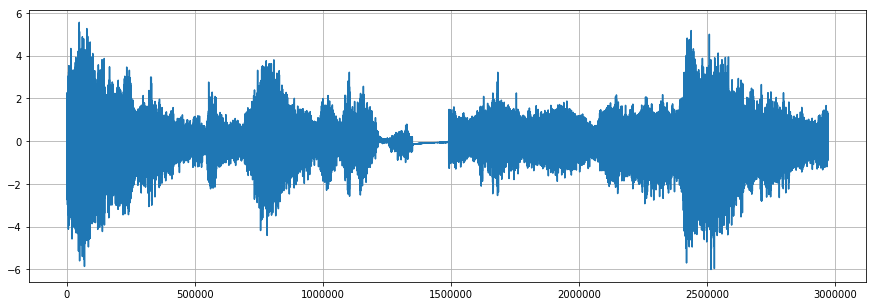

In [71]:
plt.figure(figsize=(15, 5))
plt.plot(pitch_from_df_array)
plt.title("")
plt.grid(True)

## ロジスティック回帰

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

In [91]:
with open('/Users/nakamurataiki/Dataset/df_copy_pre_trained.pickle', 'wb') as f:
    pickle.dump(df_copy, f)

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

def devide_dataset(data, label, test_size=0.3, smote_ratio={1: 10000}, is_smote=True):
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=test_size)
    if is_smote:
        X_train_resampled, y_train_resampled = SMOTEENN(ratio=smote_ratio,
                                                                                random_state=0,
                                                                                smote=SMOTE(n_jobs=3, random_state=0)
                                                                               ).fit_sample(X_train, y_train)
        print("SMOTE前: 0の数 = {} 1の数 = {}".format(len(y_train), sum(y_train)))
        print("SMOTE後: 0の数 = {} 1の数 = {}".format(len(y_train_resampled), sum(y_train_resampled)))
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        print("データバランス: 0の数 = {} 1の数 = {}".format(len(y_train), sum(y_train)))
    
    return X_train_resampled, X_test, y_train_resampled, y_test
    
    
selected_column = ['swh', 0, 1, 2, 3, 4, 5, 'Relative wind speed[m/s]']
train = df_copy.loc[:, selected_column]
test = df_copy['spc_label']

X_train_resampled, X_test, y_train_resampled, y_test = devide_dataset(train, test, 0.3, {1: 10}, False)

# 訓練
lr = LogisticRegression()
lr.fit(X_train_resampled, y_train_resampled)
y_test_predicted = lr.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predicted)
print("accuracy: {}".format(accuracy_score(y_test, y_test_predicted)))
print("precision: {}".format(precision_score(y_test, y_test_predicted)))
print("recall: {}".format(recall_score(y_test, y_test_predicted)))
print("f1_score: {}".format(f1_score(y_test, y_test_predicted)))
print(cm)

ModuleNotFoundError: No module named 'imblearn'

## 機械学習
### ロジスティック回帰
#### 結果色々

||デフォルト|SMOTEEN|
|:--|--:|:--:|
|飛沫なし|765373|1353121|
|飛沫あり|32542|709112|
|accuracy|0.957285880652891|0.1787798230584907|
|precision|0.000000000000000|0.04902563016310104|
|recall|      0.000000000000000|0.9998560011519908|
|f1-score|-|0.0934682600311628|

#### 混同行列
[[314007      0]
 [ 14011      0]]
 
 

In [100]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)
        
    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

(945188, 3) (945188,)


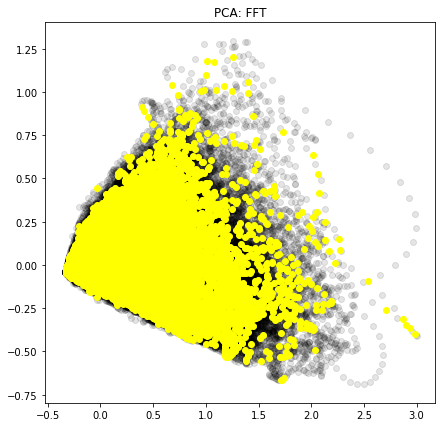

In [101]:
reduction_data = []
#reduction_data = ['swh', '速度 (kt)', '相対風速 (m/s)', 0, 1]
#reduction_data = ['Relative wind speed[m/s]', 'swh']
reduction_data.extend([i for i in range(0, 3)])
for_reduction = df_copy.loc[:, reduction_data]
label = df_copy.iloc[:, -1]
print(for_reduction.shape, label.shape)
plot_reduced_graph(for_reduction, label, 'pca_relativewind_swh', model='pca', random_sampling=False)